### 데이터셋 확인

In [1]:
!cd ~/aiffel/face_detector/widerface/wider_face_split && head -20 wider_face_train_bbx_gt.txt

0--Parade/0_Parade_marchingband_1_849.jpg
1
449 330 122 149 0 0 0 0 0 0 
0--Parade/0_Parade_Parade_0_904.jpg
1
361 98 263 339 0 0 0 0 0 0 
0--Parade/0_Parade_marchingband_1_799.jpg
21
78 221 7 8 2 0 0 0 0 0 
78 238 14 17 2 0 0 0 0 0 
113 212 11 15 2 0 0 0 0 0 
134 260 15 15 2 0 0 0 0 0 
163 250 14 17 2 0 0 0 0 0 
201 218 10 12 2 0 0 0 0 0 
182 266 15 17 2 0 0 0 0 0 
245 279 18 15 2 0 0 0 0 0 
304 265 16 17 2 0 0 0 2 1 
328 295 16 20 2 0 0 0 0 0 
389 281 17 19 2 0 0 0 2 0 
406 293 21 21 2 0 1 0 0 0 


```
0--Parade/0_Parade_marchingband_1_849.jpg   # 이미지 파일 경로
1                                           # face bounding box 개수
449 330 122 149 0 0 0 0 0 0                 # face bounding box 좌표 등 상세정보
0--Parade/0_Parade_Parade_0_904.jpg
1
361 98 263 339 0 0 0 0 0 0 
0--Parade/0_Parade_marchingband_1_799.jpg
21
78 221 7 8 2 0 0 0 0 0 
78 238 14 17 2 0 0 0 0 0 
113 212 11 15 2 0 0 0 0 0 
134 260 15 15 2 0 0 0 0 0 
163 250 14 17 2 0 0 0 0 0 
201 218 10 12 2 0 0 0 0 0 
182 266 15 17 2 0 0 0 0 0 
245 279 18 15 2 0 0 0 0 0 
304 265 16 17 2 0 0 0 2 1 
328 295 16 20 2 0 0 0 0 0 
389 281 17 19 2 0 0 0 2 0 
406 293 21 21 2 0 1 0 0 0 
```

Bounding box format
```
x0, y0, w, h, blur, expression, illumination, invalid, occlusion, pose
```

In [2]:
import os, cv2, time
import tensorflow as tf
import tqdm
import numpy as np
import math
from itertools import product
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME')+'/aiffel/face_detector'
DATA_PATH = os.path.join(PROJECT_PATH, 'widerface')
MODEL_PATH = os.path.join(PROJECT_PATH, 'checkpoints')
TRAIN_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'train_mask.tfrecord')
VALID_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'val_mask.tfrecord')
CHECKPOINT_PATH = os.path.join(PROJECT_PATH, 'checkpoints')

DATASET_LEN = 12880
BATCH_SIZE = 32
IMAGE_WIDTH = 320
IMAGE_HEIGHT = 256
IMAGE_LABELS = ['background', 'face']

print(tf.__version__)

2.6.0


In [3]:
def parse_box(data):
    x0 = int(data[0])
    y0 = int(data[1])
    w = int(data[2])
    h = int(data[3])
    return x0, y0, w, h

In [4]:
def parse_widerface(file):
    infos = []
    with open(file) as fp:
        line = fp.readline()
        while line:
            n_object = int(fp.readline())
            boxes = []
            for i in range(n_object):
                box = fp.readline().split(' ')
                x0, y0, w, h = parse_box(box)
                if (w == 0) or (h == 0):
                    continue
                boxes.append([x0, y0, w, h])
            if n_object == 0:
                box = fp.readline().split(' ')
                x0, y0, w, h = parse_box(box)
                boxes.append([x0, y0, w, h])
            infos.append((line.strip(), boxes))
            line = fp.readline()
    return infos

- bounding box : [x, y, w, h] 형태를 [x_min, y_min, x_max, y_max] 형태의 꼭짓점 좌표 정보로 변환
  - minmax 형태가 학습에 좋음

In [5]:
def process_image(image_file):
    image_string = tf.io.read_file(image_file)
    try:
        image_data = tf.image.decode_jpeg(image_string, channels=3)
        return 0, image_string, image_data
    except tf.errors.InvalidArgumentError:
        return 1, image_string, None

In [6]:
def xywh_to_voc(file_name, boxes, image_data):
    shape = image_data.shape
    image_info = {}
    image_info['filename'] = file_name
    image_info['width'] = shape[1]
    image_info['height'] = shape[0]
    image_info['depth'] = 3

    difficult = []
    classes = []
    xmin, ymin, xmax, ymax = [], [], [], []

    for box in boxes:
        classes.append(1)
        difficult.append(0)
        xmin.append(box[0])
        ymin.append(box[1])
        xmax.append(box[0] + box[2])
        ymax.append(box[1] + box[3])
        
    image_info['class'] = classes
    image_info['xmin'] = xmin
    image_info['ymin'] = ymin
    image_info['xmax'] = xmax
    image_info['ymax'] = ymax
    image_info['difficult'] = difficult

    return image_info

In [7]:
file_path = os.path.join(DATA_PATH, 'wider_face_split', 'wider_face_train_bbx_gt.txt')
for i, info in enumerate(parse_widerface(file_path)):
    print('--------------------')
    image_file = os.path.join(DATA_PATH, 'WIDER_train', 'images', info[0])
    _, image_string, image_data = process_image(image_file)
    boxes = xywh_to_voc(image_file, info[1], image_data)
    print(boxes)
    if i > 3:
        break

--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg', 'width': 1024, 'height': 1385, 'depth': 3, 'class': [1], 'xmin': [449], 'ymin': [330], 'xmax': [571], 'ymax': [479], 'difficult': [0]}
--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_Parade_0_904.jpg', 'width': 1024, 'height': 1432, 'depth': 3, 'class': [1], 'xmin': [361], 'ymin': [98], 'xmax': [624], 'ymax': [437], 'difficult': [0]}
--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_799.jpg', 'width': 1024, 'height': 768, 'depth': 3, 'class': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'xmin': [78, 78, 113, 134, 163, 201, 182, 245, 304, 328, 389, 406, 436, 522, 643, 653, 793, 535, 29, 3, 20], 'ymin': [221, 238, 212, 260, 250, 218, 266, 279, 265, 295, 281, 293, 290, 328, 320, 224, 337, 311, 22

### [TFRecord](https://www.tensorflow.org/tutorials/load_data/tfrecord) 생성
- TFRecord
  - TensorFlow만의 학습 데이터 저장 포맷
  - 이진(binary) 레코드의 시퀀스를 저장
  - 학습 속도 개선
- 대용량 데이터의 처리 속도 향상을 위해 TFRecord로 변화하는 전처리 작업 수행

In [8]:
def make_example(image_string, image_infos):
    for info in image_infos:
        filename = info['filename']
        width = info['width']
        height = info['height']
        depth = info['depth']
        classes = info['class']
        xmin = info['xmin']
        ymin = info['ymin']
        xmax = info['xmax']
        ymax = info['ymax']

    if isinstance(image_string, type(tf.constant(0))):
        encoded_image = [image_string.numpy()]
    else:
        encoded_image = [image_string]

    base_name = [tf.compat.as_bytes(os.path.basename(filename))]
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'filename':tf.train.Feature(bytes_list=tf.train.BytesList(value=base_name)),
        'height':tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'width':tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'classes':tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'x_mins':tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'y_mins':tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'x_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'y_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image_raw':tf.train.Feature(bytes_list=tf.train.BytesList(value=encoded_image))
    }))
    
    return example

- tf.train.Example의 프로토콜 버퍼 형식을 사용하여 데이터를 표현하고 파일로 저장

In [9]:
for split in ['train', 'val']:
    if split == 'train':
        output_file = TRAIN_TFRECORD_PATH 
        anno_txt = 'wider_face_train_bbx_gt.txt'
        file_path = 'WIDER_train'
    else:
        output_file = VALID_TFRECORD_PATH
        anno_txt = 'wider_face_val_bbx_gt.txt'
        file_path = 'WIDER_val'

    with tf.io.TFRecordWriter(output_file) as writer:
        for info in tqdm.tqdm(parse_widerface(os.path.join(DATA_PATH, 'wider_face_split', anno_txt))):
            image_file = os.path.join(DATA_PATH, file_path, 'images', info[0])
            error, image_string, image_data = process_image(image_file)
            boxes = xywh_to_voc(image_file, info[1], image_data)

            if not error:
                tf_example = make_example(image_string, [boxes])
                writer.write(tf_example.SerializeToString())

100%|██████████| 3226/3226 [00:13<00:00, 233.74it/s]


In [10]:
!ls ~/aiffel/face_detector/dataset

train_mask.tfrecord  val_mask.tfrecord


```
train_mask.tfrecord  val_mask.tfrecord
```

### SSD 구현

#### Default boxes
![default_boxes](https://manalelaidouni.github.io/assets/img/pexels/SSD.jpg)  
- object가 존재할 만한 다양한 크기의 box의 좌표 및 클래스 정보를 일정 개수만큼 미리 고정해 둔 것
- 다른 말로 anchor, prior box
- Default box 필요 : SSD 모델의 가장 중요한 특징 중 하나
- SSD 모델에서의 default box는 여러 층의 feature map에서 box를 만들어 냄
  - 층 수 만큼 box 수도 많아지고, 층마다 box의 크기도 다양함
- ground truth에 해당하는 bounding box와의 IoU를 계산하여 일정 크기(0.5) 이상 겹치는 default box를 선택
  - RCNN 계열의 sliding window 방식보다 훨씬 속도가 빠르면서도 그와 유사한 정도의 정확도를 얻을 수 있음


In [11]:
# 프로젝트에서 사용할 default box 정보를 전역 변수로 정의
BOX_MIN_SIZES = [[10, 16, 24], [32, 48], [64, 96], [128, 192, 256]]
BOX_STEPS = [8, 16, 32, 64]

![feature_maps](https://towardsdatascience.com/wp-content/uploads/2017/11/1JuhjYUWXgfxMMoa4SIKLkA.png)  
- default box를 생성하기 위해서는 먼저 기준이 되는 feature map을 먼저 생성
- 프로젝트에서는 아래와 같이 4가지 유형의 feature map을 생성

In [12]:
image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
min_sizes = BOX_MIN_SIZES
steps= BOX_STEPS

feature_maps = [
    [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
    for step in steps
]
feature_maps

[[32, 40], [16, 20], [8, 10], [4, 5]]

- feature map별로 순회를 하면서 default box 를 생성

In [13]:
boxes = []
for k, f in enumerate(feature_maps):
    for i, j in product(range(f[0]), range(f[1])):
        for min_size in min_sizes[k]:
            s_kx = min_size / image_sizes[1]
            s_ky = min_size / image_sizes[0]
            cx = (j + 0.5) * steps[k] / image_sizes[1]
            cy = (i + 0.5) * steps[k] / image_sizes[0]
            boxes += [cx, cy, s_kx, s_ky]

len(boxes)

18800

- 생성된 boxes에는 default box 정보가 구분없이 나열되어 있으므로 4개씩 재배열

In [14]:
pretty_boxes = np.asarray(boxes).reshape([-1, 4])
print(pretty_boxes.shape)
print(pretty_boxes)

(4700, 4)
[[0.0125    0.015625  0.03125   0.0390625]
 [0.0125    0.015625  0.05      0.0625   ]
 [0.0125    0.015625  0.075     0.09375  ]
 ...
 [0.9       0.875     0.4       0.5      ]
 [0.9       0.875     0.6       0.75     ]
 [0.9       0.875     0.8       1.       ]]


- feature_maps와 min_sizes로부터 40x32x3 + 20x16x2 + 10x8x2 + 5x4x3 개가 생성
- feature map을 만들고 그에 연결된 default box를 생성하는 함수 정의

In [15]:
def default_box():
    image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
    min_sizes = BOX_MIN_SIZES
    steps= BOX_STEPS
    feature_maps = [
        [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
        for step in steps
    ]
    boxes = []
    for k, f in enumerate(feature_maps):
        for i, j in product(range(f[0]), range(f[1])):
            for min_size in min_sizes[k]:
                s_kx = min_size / image_sizes[1]
                s_ky = min_size / image_sizes[0]
                cx = (j + 0.5) * steps[k] / image_sizes[1]
                cy = (i + 0.5) * steps[k] / image_sizes[0]
                boxes += [cx, cy, s_kx, s_ky]
    boxes = np.asarray(boxes).reshape([-1, 4])
    return boxes

#### SSD model 빌드

In [16]:
def _conv_block(inputs, filters, kernel=(3, 3), strides=(1, 1)):
    block_id = (tf.keras.backend.get_uid())
    if strides == (2, 2):
        x = tf.keras.layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='valid',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(x)
    else:
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='same',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(inputs)
    
    x = tf.keras.layers.BatchNormalization(name='conv_bn_%d' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_relu_%d' % block_id)(x)

In [17]:
def _depthwise_conv_block(inputs, filters, strides=(1, 1)):
    block_id = tf.keras.backend.get_uid()
    if strides == (1, 1):
        x = inputs
    else:
        x = tf.keras.layers.ZeroPadding2D(((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
    x = tf.keras.layers.DepthwiseConv2D((3, 3),
                                        padding='same' if strides == (1, 1) else 'valid',
                                        strides=strides,
                                        use_bias=False,
                                        name='conv_dw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_dw_%d_bn' % block_id)(x)
    x = tf.keras.layers.ReLU(name='conv_dw_%d_relu' % block_id)(x)
    x = tf.keras.layers.Conv2D(filters, (1, 1),
                               padding='same',
                               use_bias=False,
                               strides=(1, 1),
                               name='conv_pw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_pw_%d_bn' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_pw_%d_relu' % block_id)(x)

In [18]:
def _branch_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x1 = tf.keras.layers.Conv2D(filters * 2, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.Concatenate(axis=-1)([x, x1])
    return tf.keras.layers.ReLU()(x)

- 여러 블록을 쌓아 모델을 만든 후, 중간중간 Branch 부분에 헤드(head) 라고 불리는 Convolution 레이어를 붙임
- 하나의 헤드에 Convolution 레이어 두 개가 필요
- 하나는 confidence를 예측하기 위해 사용하고 다른 하나는 location을 예측하기 위해 사용

In [19]:
def _create_head_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    return x

In [20]:
def _compute_heads(inputs, num_class, num_cell):
    conf = _create_head_block(inputs, num_cell * num_class)
    conf = tf.keras.layers.Reshape((-1, num_class))(conf)
    loc = _create_head_block(inputs, num_cell * 4)
    loc = tf.keras.layers.Reshape((-1, 4))(loc)
    return conf, loc

- SSD model

In [21]:
def SsdModel():
    base_channel = 16
    num_cells = [3, 2, 2, 3]
    num_class = len(IMAGE_LABELS)
    
    x = inputs = tf.keras.layers.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3], name='input_image')

    x = _conv_block(x, base_channel, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 2, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(2, 2))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x1 = _branch_block(x, base_channel)

    x = _conv_block(x, base_channel * 8, strides=(2, 2))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x2 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x = _depthwise_conv_block(x, base_channel * 16, strides=(1, 1))
    x3 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x4 = _branch_block(x, base_channel)

    extra_layers = [x1, x2, x3, x4]

    confs = []
    locs = []

    for layer, num_cell in zip(extra_layers, num_cells):
        conf, loc = _compute_heads(layer, num_class, num_cell)
        confs.append(conf)
        locs.append(loc)

    confs = tf.keras.layers.Concatenate(axis=1, name="face_classes")(confs)
    locs = tf.keras.layers.Concatenate(axis=1, name="face_boxes")(locs)

    predictions = tf.keras.layers.Concatenate(axis=2, name='predictions')([locs, confs])

    model = tf.keras.Model(inputs=inputs, outputs=predictions, name='ssd_model')
    return model

In [22]:
model = SsdModel()
print("the number of model layers: ", len(model.layers))
model.summary()

the number of model layers:  101
Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
conv_pad_1 (ZeroPadding2D)      (None, 258, 322, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 128, 160, 16) 432         conv_pad_1[0][0]                 
__________________________________________________________________________________________________
conv_bn_1 (BatchNormalization)  (None, 128, 160, 16) 64          conv_1[0][0]                     
_________________________________________________________

- 101층의 SSD 모델

#### Training
- Augmentation, jaccard 적용  

**Augmentation**  
- `tf.data.TFRecordDataset.map()`
  - `_crop`
  - `_pad_to_square`
  - `_resize`
  - `_flip`
  - `_distort`
- 이미지가 변경되면서 box의 위치나 크기도 함께 변경되어야 하기 때문에 함수가 복잡
- 이미지를 `_crop`했을 때 box도 함께 잘릴 수가 있으니 함께 고려


In [23]:
def _crop(img, labels, max_loop=250):
    shape = tf.shape(img)

    def matrix_iof(a, b):
        lt = tf.math.maximum(a[:, tf.newaxis, :2], b[:, :2])
        rb = tf.math.minimum(a[:, tf.newaxis, 2:], b[:, 2:])

        area_i = tf.math.reduce_prod(rb - lt, axis=2) * \
            tf.cast(tf.reduce_all(lt < rb, axis=2), tf.float32)
        area_a = tf.math.reduce_prod(a[:, 2:] - a[:, :2], axis=1)
        return area_i / tf.math.maximum(area_a[:, tf.newaxis], 1)

    def crop_loop_body(i, img, labels):
        valid_crop = tf.constant(1, tf.int32)

        pre_scale = tf.constant([0.3, 0.45, 0.6, 0.8, 1.0], dtype=tf.float32)
        scale = pre_scale[tf.random.uniform([], 0, 5, dtype=tf.int32)]
        short_side = tf.cast(tf.minimum(shape[0], shape[1]), tf.float32)
        h = w = tf.cast(scale * short_side, tf.int32)
        h_offset = tf.random.uniform([], 0, shape[0] - h + 1, dtype=tf.int32)
        w_offset = tf.random.uniform([], 0, shape[1] - w + 1, dtype=tf.int32)
        roi = tf.stack([w_offset, h_offset, w_offset + w, h_offset + h])
        roi = tf.cast(roi, tf.float32)

        value = matrix_iof(labels[:, :4], roi[tf.newaxis])
        valid_crop = tf.cond(tf.math.reduce_any(value >= 1),
                             lambda: valid_crop, lambda: 0)

        centers = (labels[:, :2] + labels[:, 2:4]) / 2
        mask_a = tf.reduce_all(
            tf.math.logical_and(roi[:2] < centers, centers < roi[2:]),
            axis=1)
        labels_t = tf.boolean_mask(labels, mask_a)
        valid_crop = tf.cond(tf.reduce_any(mask_a),
                             lambda: valid_crop, lambda: 0)

        img_t = img[h_offset:h_offset + h, w_offset:w_offset + w, :]
        h_offset = tf.cast(h_offset, tf.float32)
        w_offset = tf.cast(w_offset, tf.float32)
        labels_t = tf.stack(
            [labels_t[:, 0] - w_offset,  labels_t[:, 1] - h_offset,
             labels_t[:, 2] - w_offset,  labels_t[:, 3] - h_offset,
             labels_t[:, 4]], axis=1)

        return tf.cond(valid_crop == 1,
                       lambda: (max_loop, img_t, labels_t),
                       lambda: (i + 1, img, labels))

    _, img, labels = tf.while_loop(
        lambda i, img, labels: tf.less(i, max_loop),
        crop_loop_body,
        [tf.constant(-1), img, labels],
        shape_invariants=[tf.TensorShape([]),
                          tf.TensorShape([None, None, 3]),
                          tf.TensorShape([None, 5])])

    return img, labels

- `_resize`나 `_flip`도 box에 영향

In [24]:
def _resize(img, labels):
    w_f = tf.cast(tf.shape(img)[1], tf.float32)
    h_f = tf.cast(tf.shape(img)[0], tf.float32)
    locs = tf.stack([labels[:, 0] / w_f,  labels[:, 1] / h_f,
                     labels[:, 2] / w_f,  labels[:, 3] / h_f] ,axis=1)
    locs = tf.clip_by_value(locs, 0, 1.0)
    labels = tf.concat([locs, labels[:, 4][:, tf.newaxis]], axis=1)

    resize_case = tf.random.uniform([], 0, 5, dtype=tf.int32)

    def resize(method):
        def _resize():
            #　size h,w
            return tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH], method=method, antialias=True)
        return _resize

    img = tf.case([(tf.equal(resize_case, 0), resize('bicubic')),
                   (tf.equal(resize_case, 1), resize('area')),
                   (tf.equal(resize_case, 2), resize('nearest')),
                   (tf.equal(resize_case, 3), resize('lanczos3'))],
                  default=resize('bilinear'))

    return img, labels

In [25]:
def _flip(img, labels):
    flip_case = tf.random.uniform([], 0, 2, dtype=tf.int32)

    def flip_func():
        flip_img = tf.image.flip_left_right(img)
        flip_labels = tf.stack([1 - labels[:, 2],  labels[:, 1],
                                1 - labels[:, 0],  labels[:, 3],
                                labels[:, 4]], axis=1)

        return flip_img, flip_labels

    img, labels = tf.case([(tf.equal(flip_case, 0), flip_func)],default=lambda: (img, labels))

    return img, labels

- `_pad_to_square`는 이미지가 정사각형이 되도록 이미지 오른쪽이나 아래 방향으로 평균 색상 영역을 추가해주는 작업
- 이미지 왼쪽이나 위쪽으로는 변화가 없기 때문에 box 정보는 변하지 않음

In [26]:
def _pad_to_square(img):
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]

    def pad_h():
        img_pad_h = tf.ones([width - height, width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_h], axis=0)

    def pad_w():
        img_pad_w = tf.ones([height, height - width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_w], axis=1)

    img = tf.case([(tf.greater(height, width), pad_w),
                   (tf.less(height, width), pad_h)], default=lambda: img)
    return img

- 이미지 색상 값만 바꿔주는 `_distort`에서도 box 정보를 바꿀 필요는 없음

In [27]:
def _distort(img):
    img = tf.image.random_brightness(img, 0.4)
    img = tf.image.random_contrast(img, 0.5, 1.5)
    img = tf.image.random_saturation(img, 0.5, 1.5)
    img = tf.image.random_hue(img, 0.1)

    return img

**Default box 적용**  
- IoU (== jaccard index) 사용
- Jaccard 유사도
  - 두 개의 집합이 얼마나 유사한 지를 측정
  - 두 집합의 교집합 크기를 두 집합의 합집합 크기로 나눠서 계산
  - 0과 1 사이의 값
  - 1에 가까운 값이 나올 수록 두 집합이 유사

In [28]:
def _intersect(box_a, box_b):
    A = tf.shape(box_a)[0]
    B = tf.shape(box_b)[0]
    max_xy = tf.minimum(
        tf.broadcast_to(tf.expand_dims(box_a[:, 2:], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, 2:], 0), [A, B, 2]))
    min_xy = tf.maximum(
        tf.broadcast_to(tf.expand_dims(box_a[:, :2], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, :2], 0), [A, B, 2]))
    inter = tf.clip_by_value(max_xy - min_xy, 0.0, 512.0)
    return inter[:, :, 0] * inter[:, :, 1]

In [29]:
def _jaccard(box_a, box_b):
    inter = _intersect(box_a, box_b)
    area_a = tf.broadcast_to(
        tf.expand_dims(
            (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]), 1),
        tf.shape(inter))  # [A,B]
    area_b = tf.broadcast_to(
        tf.expand_dims(
            (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]), 0),
        tf.shape(inter))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

- `encode_tf()` 함수
  - TFRecord 데이터셋의 라벨을 가공
  - jaccard 메소드를 이용해 label의 ground truth bbox와 가장 overlap 비율이 높은 matched box를 구함
  - `_encode_bbox` 메소드를 통해 bbox의 scale을 동일하게 보정
  - 전체 default box에 대해 일정 threshold 이상 overlap되는 ground truth bounding box 존재 여부(positive/negative)를 concat하여 새로운 label로 업데이트

In [30]:
def _encode_bbox(matched, boxes, variances=[0.1, 0.2]):
    g_cxcy = (matched[:, :2] + matched[:, 2:]) / 2 - boxes[:, :2]
    g_cxcy /= (variances[0] * boxes[:, 2:])
    g_wh = (matched[:, 2:] - matched[:, :2]) / boxes[:, 2:]
    g_wh = tf.math.log(g_wh) / variances[1]
    g_wh = tf.where(tf.math.is_inf(g_wh), 0.0, g_wh)
    return tf.concat([g_cxcy, g_wh], 1)

In [31]:
def encode_tf(labels, boxes):
    match_threshold = 0.45
    boxes = tf.cast(boxes, tf.float32)
    bbox = labels[:, :4]
    conf = labels[:, -1]
   
    # jaccard index
    overlaps = _jaccard(bbox, boxes)
    best_box_overlap = tf.reduce_max(overlaps, 1)
    best_box_idx = tf.argmax(overlaps, 1, tf.int32)

    best_truth_overlap = tf.reduce_max(overlaps, 0)
    best_truth_idx = tf.argmax(overlaps, 0, tf.int32)

    best_truth_overlap = tf.tensor_scatter_nd_update(
        best_truth_overlap, tf.expand_dims(best_box_idx, 1),
        tf.ones_like(best_box_idx, tf.float32) * 2.)
    best_truth_idx = tf.tensor_scatter_nd_update(
        best_truth_idx, tf.expand_dims(best_box_idx, 1),
        tf.range(tf.size(best_box_idx), dtype=tf.int32))
    # Scale Ground-Truth Boxes   
    matches_bbox = tf.gather(bbox, best_truth_idx)
    loc_t = _encode_bbox(matches_bbox, boxes)
    conf_t = tf.gather(conf, best_truth_idx)
    conf_t = tf.where(tf.less(best_truth_overlap, match_threshold), tf.zeros_like(conf_t), conf_t)

    return tf.concat([loc_t, conf_t[..., tf.newaxis]], axis=1)

- `load_dataset()` 함수
  - `_transform_data` : augmemtation과 label을 encoding 하여 기존의 dataset을 변환하는 메소드
  - `_parse_tfrecord` : TFRecord 에 `_transform_data`를 적용하는 함수 클로저 생성
  - `load_tfrecord_dataset` : `tf.data.TFRecordDataset.map()`에 `_parse_tfrecord`을 적용하는 실제 데이터셋 변환 메인 메소드
  - `load_dataset` : `load_tfrecord_dataset`을 통해 train, validation 데이터셋을 생성하는 최종 메소드

In [32]:
def _transform_data(train, boxes):
    def transform_data(img, labels):
        img = tf.cast(img, tf.float32)
        if train:
            img, labels = _crop(img, labels)
            img = _pad_to_square(img)

        img, labels = _resize(img, labels)

        if train:
            img, labels = _flip(img, labels)

        if train:
            img = _distort(img)
        labels = encode_tf(labels, boxes)        
        img = img/255.0
        return img, labels
    return transform_data

In [33]:
def _parse_tfrecord(train, boxes):
    def parse_tfrecord(tfrecord):
        features = {
            'filename': tf.io.FixedLenFeature([], tf.string),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'classes': tf.io.VarLenFeature(tf.int64),
            'x_mins': tf.io.VarLenFeature(tf.float32),
            'y_mins': tf.io.VarLenFeature(tf.float32),
            'x_maxes': tf.io.VarLenFeature(tf.float32),
            'y_maxes': tf.io.VarLenFeature(tf.float32),
            'difficult':tf.io.VarLenFeature(tf.int64),
            'image_raw': tf.io.FixedLenFeature([], tf.string),
           }

        parsed_example = tf.io.parse_single_example(tfrecord, features)
        img = tf.image.decode_jpeg(parsed_example['image_raw'], channels=3)

        width = tf.cast(parsed_example['width'], tf.float32)
        height = tf.cast(parsed_example['height'], tf.float32)

        labels = tf.sparse.to_dense(parsed_example['classes'])
        labels = tf.cast(labels, tf.float32)

        labels = tf.stack(
            [tf.sparse.to_dense(parsed_example['x_mins']),
             tf.sparse.to_dense(parsed_example['y_mins']),
             tf.sparse.to_dense(parsed_example['x_maxes']),
             tf.sparse.to_dense(parsed_example['y_maxes']),labels], axis=1)

        img, labels = _transform_data(train, boxes)(img, labels)

        return img, labels
    return parse_tfrecord

In [34]:
def load_tfrecord_dataset(tfrecord_name, train=True, boxes=None, buffer_size=1024):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_name)
    raw_dataset = raw_dataset.cache()
    if train:
        raw_dataset = raw_dataset.repeat()
        raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)

    dataset = raw_dataset.map(_parse_tfrecord(train, boxes), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [35]:
def load_dataset(boxes, train=True, buffer_size=1024):
    if train:
        dataset = load_tfrecord_dataset(
            tfrecord_name=TRAIN_TFRECORD_PATH,
            train=train,
            boxes=boxes,
            buffer_size=buffer_size)
    else:
        dataset = load_tfrecord_dataset(
            tfrecord_name=VALID_TFRECORD_PATH,
            train=train,
            boxes=boxes,
            buffer_size=buffer_size)
    return dataset

### Train
#### Learning rate scheduler
- 초기시점에 WarmUp부분을 도입해 learning rate가 천천히 증가
- 학습 스텝에 따라 다른 Learning Rate이 적용

In [36]:
class PiecewiseConstantWarmUpDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, boundaries, values, warmup_steps, min_lr, name=None):
        super(PiecewiseConstantWarmUpDecay, self).__init__()

        if len(boundaries) != len(values) - 1:
            raise ValueError(
                    "The length of boundaries should be 1 less than the"
                    "length of values")

        self.boundaries = boundaries
        self.values = values
        self.name = name
        self.warmup_steps = warmup_steps
        self.min_lr = min_lr

    def __call__(self, step):
        with tf.name_scope(self.name or "PiecewiseConstantWarmUp"):
            step = tf.cast(tf.convert_to_tensor(step), tf.float32)
            pred_fn_pairs = []
            warmup_steps = self.warmup_steps
            boundaries = self.boundaries
            values = self.values
            min_lr = self.min_lr

            pred_fn_pairs.append(
                (step <= warmup_steps,
                 lambda: min_lr + step * (values[0] - min_lr) / warmup_steps))
            pred_fn_pairs.append(
                (tf.logical_and(step <= boundaries[0],
                                step > warmup_steps),
                 lambda: tf.constant(values[0])))
            pred_fn_pairs.append(
                (step > boundaries[-1], lambda: tf.constant(values[-1])))

            for low, high, v in zip(boundaries[:-1], boundaries[1:],
                                    values[1:-1]):
                pred = (step > low) & (step <= high)
                pred_fn_pairs.append((pred, lambda: tf.constant(v)))

            return tf.case(pred_fn_pairs, lambda: tf.constant(values[0]),
                           exclusive=True)

In [37]:
def MultiStepWarmUpLR(initial_learning_rate, lr_steps, lr_rate,
                      warmup_steps=0., min_lr=0.,
                      name='MultiStepWarmUpLR'):
    assert warmup_steps <= lr_steps[0]
    assert min_lr <= initial_learning_rate
    lr_steps_value = [initial_learning_rate]
    for _ in range(len(lr_steps)):
        lr_steps_value.append(lr_steps_value[-1] * lr_rate)
    return PiecewiseConstantWarmUpDecay(
        boundaries=lr_steps, values=lr_steps_value, warmup_steps=warmup_steps,
        min_lr=min_lr)

#### **Hard negative mining**
- 학습과정에서 label은 negative인데 confidence가 높게 나오는 샘플을 재학습하면 positive와 negative의 모호한 경계선상에 분포한 false negative 오류에 강해진다는 장점
- 실제로 confidence가 높은 샘플을 모아 training을 다시 수행하기보다는, 그런 샘플들에 대한 **loss만 따로 모아 계산해주는 방식**으로 반영
- Object Detection에서는 물체 영역보다 배경 영역이 훨씬 많으니, negative 비율을 positive의 3배가 되도록 설정해 줌

_`hard_negative_mining` 메소드와, 이 메소드를 통해 얻은 샘플을 통해 얻은 localization loss를 기존의 classification loss에 추가로 반영하는 MultiBoxLoss 계산 메소드를 확인_

In [38]:
def hard_negative_mining(loss, class_truth, neg_ratio):
    pos_idx = class_truth > 0
    num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.int32), axis=1)
    num_neg = num_pos * neg_ratio

    rank = tf.argsort(loss, axis=1, direction='DESCENDING')
    rank = tf.argsort(rank, axis=1)
    neg_idx = rank < tf.expand_dims(num_neg, 1)

    return pos_idx, neg_idx

In [39]:
import tensorflow_addons as tfa

In [ ]:
def MultiBoxLoss(num_class, neg_pos_ratio=3.0, alpha=0.25, gamma=2.0):
    def multi_loss(y_true, y_pred):
        num_batch = tf.shape(y_true)[0]
        loc_pred, class_pred = y_pred[..., :4], y_pred[..., 4:]
        loc_truth, class_truth = y_true[..., :4], tf.squeeze(y_true[..., 4:])

        ###
        # Classification Loss
        ###
        # cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        # temp_loss = cross_entropy(class_truth, class_pred)
        
        # pos_idx, neg_idx = hard_negative_mining(temp_loss, class_truth, neg_pos_ratio)
        
        # cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='sum')
        # loss_class = cross_entropy(
        #     class_truth[tf.math.logical_or(pos_idx, neg_idx)],
        #     class_pred[tf.math.logical_or(pos_idx, neg_idx)])
        
        # binary classification
        # cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction='none')
        # temp_loss = cross_entropy(tf.one_hot(tf.cast(class_truth, tf.int32), depth=num_class), class_pred)
        
        # pos_idx, neg_idx = hard_negative_mining(temp_loss, class_truth, neg_pos_ratio)
        
        # cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction='sum')
        # loss_class = cross_entropy(
        #     tf.one_hot(tf.cast(class_truth[tf.logical_or(pos_idx, neg_idx)], tf.int32), depth=num_class),
        #     class_pred[tf.logical_or(pos_idx, neg_idx)]
        # )
        
        # focal loss
        # Convert sparse labels to one-hot encoding for focal loss
        class_truth_one_hot = tf.one_hot(tf.cast(class_truth, tf.int32), depth=num_class)
        
        # Apply sigmoid focal cross entropy
        focal_loss = tfa.losses.SigmoidFocalCrossEntropy(
            alpha=alpha,
            gamma=gamma,
            reduction=tf.keras.losses.Reduction.NONE
        )
        
        # Calculate per-anchor classification loss
        temp_loss = focal_loss(class_truth_one_hot, class_pred)
        
        # Continue with hard negative mining if still needed
        pos_idx, neg_idx = hard_negative_mining(temp_loss, class_truth, neg_pos_ratio)
        
        focal_loss_sum = tfa.losses.SigmoidFocalCrossEntropy(
            alpha=alpha,
            gamma=gamma,
            reduction=tf.keras.losses.Reduction.SUM
        )

        # Get only the selected indices for loss calculation
        selected_indices = tf.math.logical_or(pos_idx, neg_idx)
        loss_class = focal_loss_sum(
            class_truth_one_hot[selected_indices],
            class_pred[selected_indices]
        )
        
        ###
        # Localization Loss
        ###
        smooth_l1_loss = tf.keras.losses.Huber(reduction='sum')
        loss_loc = smooth_l1_loss(loc_truth[pos_idx],loc_pred[pos_idx])
        
        # giou loss
        # giou_loss = tfa.losses.GIoULoss(reduction='sum')
        # loss_loc = giou_loss(loc_truth[pos_idx],loc_pred[pos_idx])

        # TODO: CIoU loss
        
        num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.float32))
        # num_pos = tf.maximum(num_pos, 1.0)  # NaN 방지

        loss_class = loss_class / num_pos
        loss_loc = loss_loc / num_pos
        return loss_loc, loss_class

    return multi_loss

#### Training

In [41]:
boxes = default_box()
train_dataset = load_dataset(boxes, train=True)

Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
conv_pad_15 (ZeroPadding2D)     (None, 258, 322, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv_15 (Conv2D)                (None, 128, 160, 16) 432         conv_pad_15[0][0]                
__________________________________________________________________________________________________
conv_bn_15 (BatchNormalization) (None, 128, 160, 16) 64          conv_15[0][0]                    
__________________________________________________________________________________________

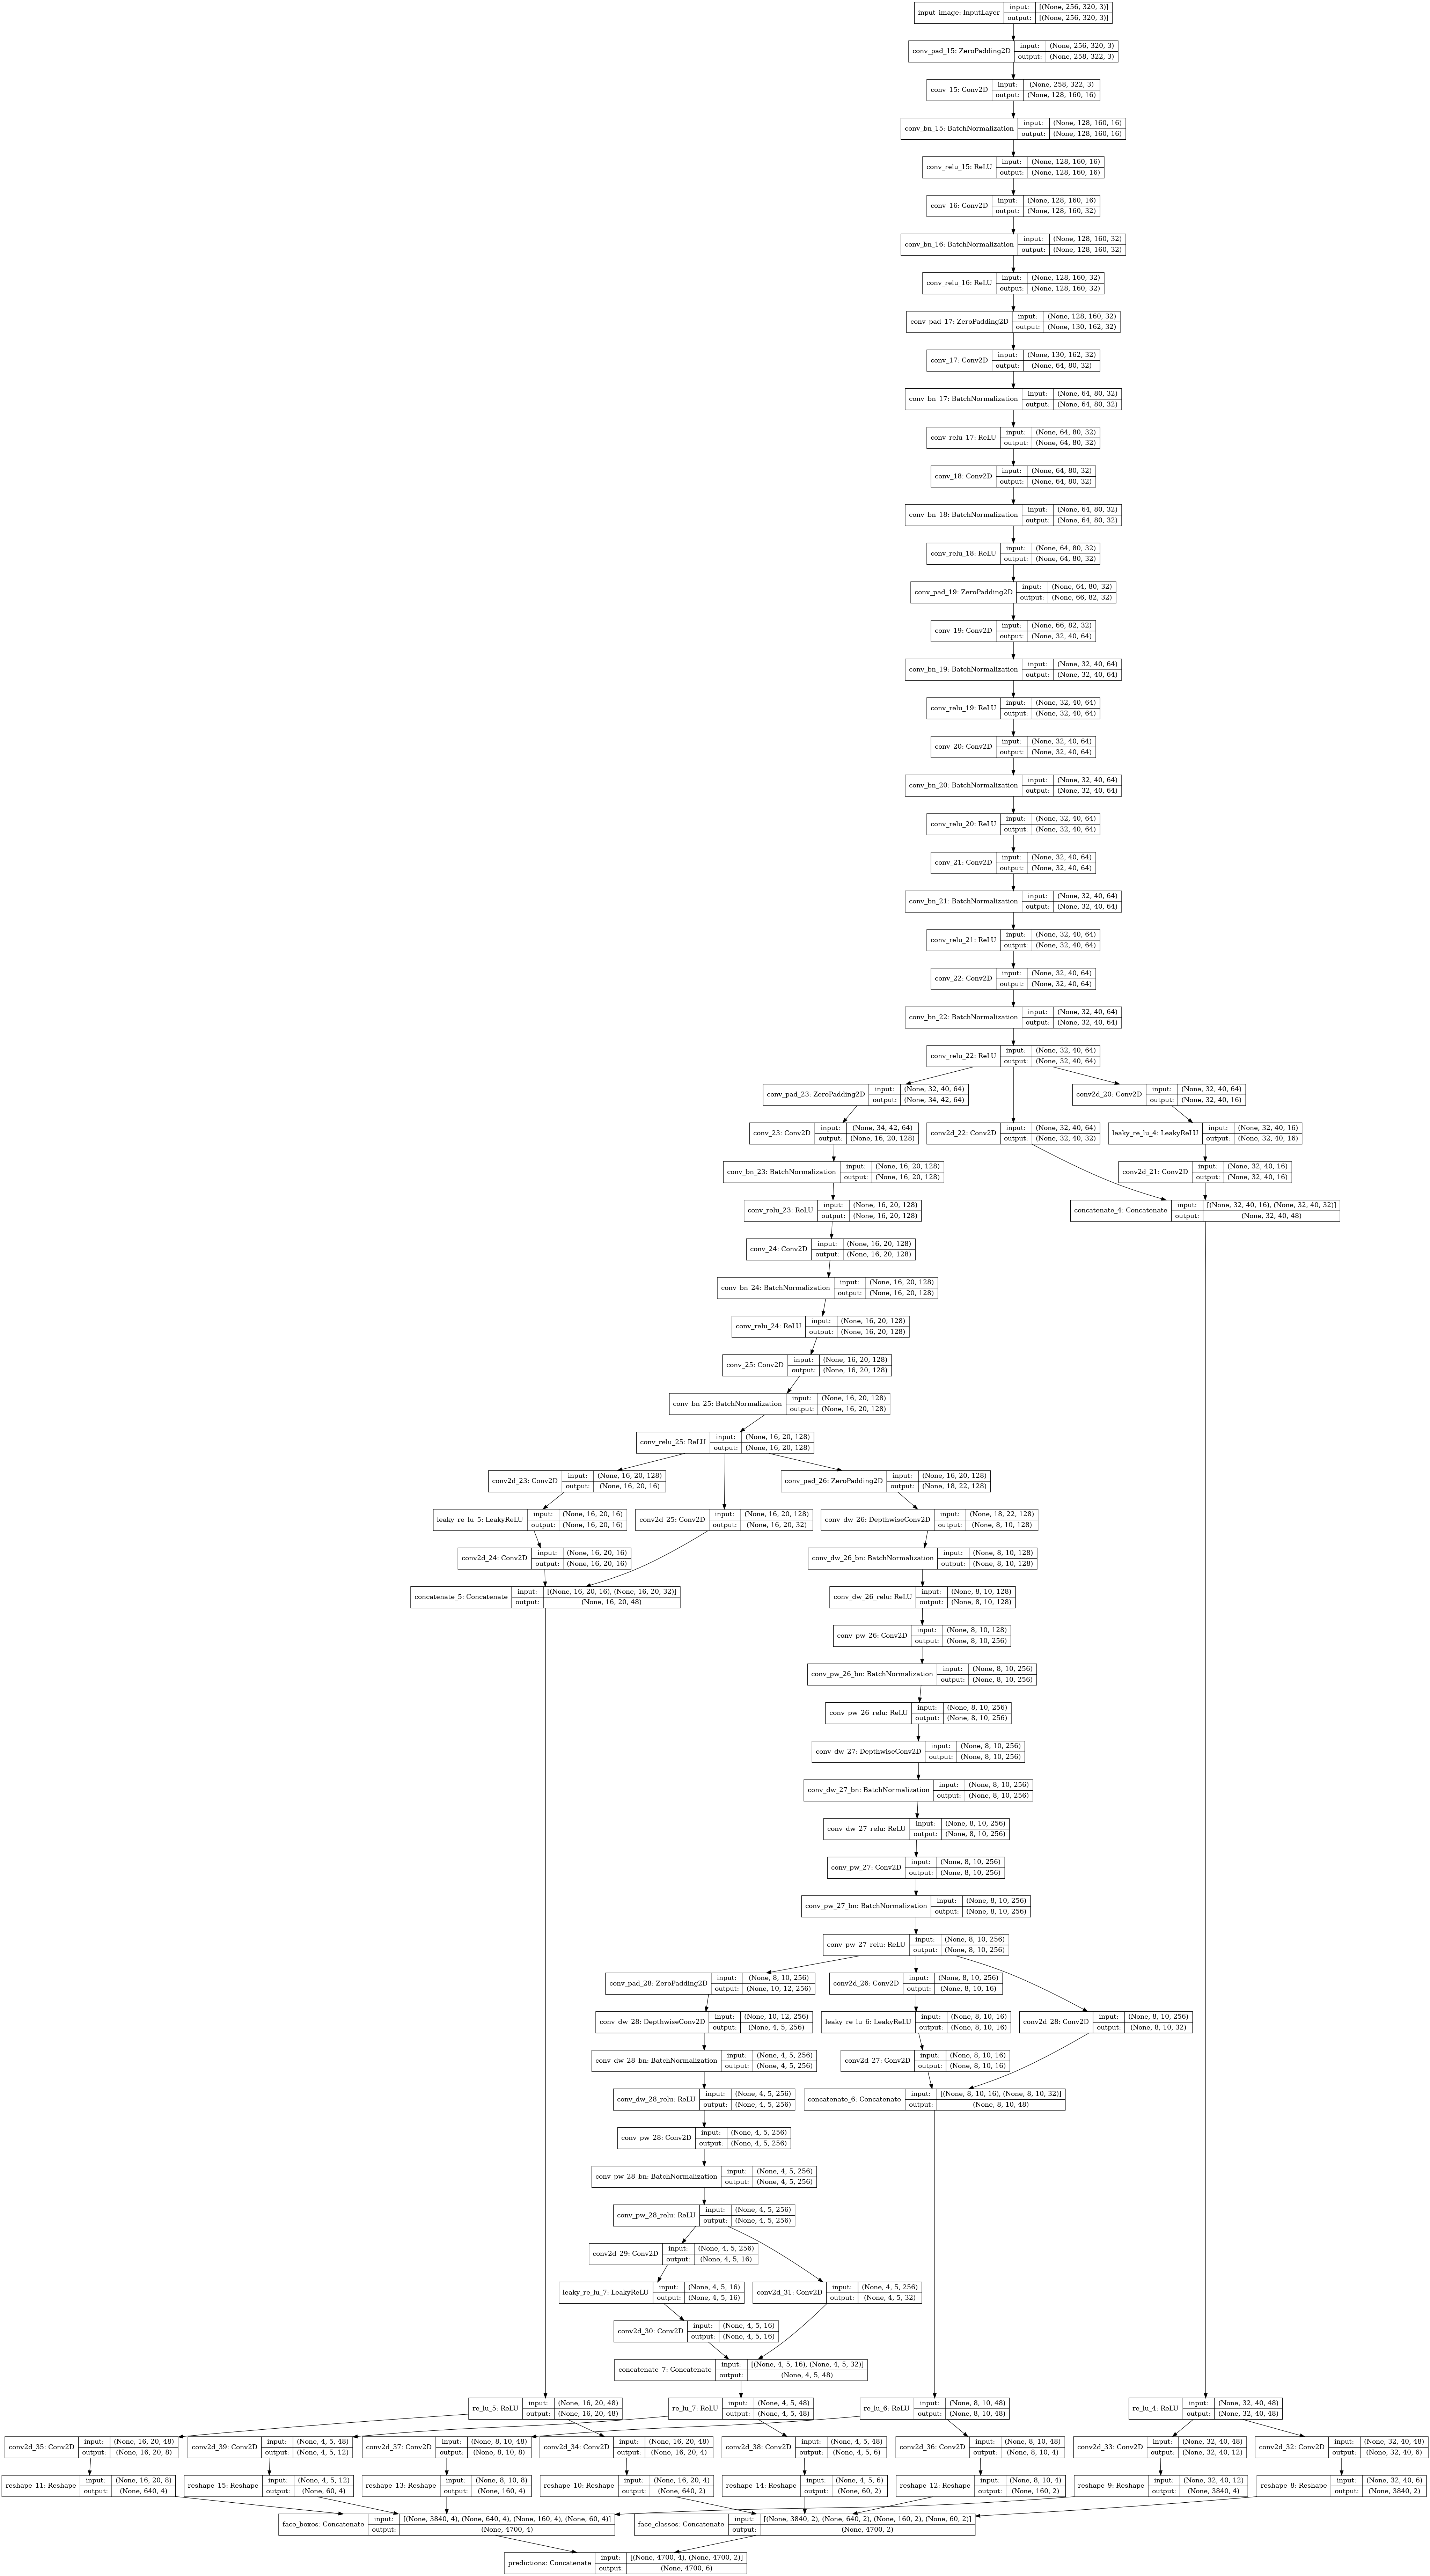

In [42]:
model = SsdModel()
model.summary()
tf.keras.utils.plot_model(
    model, 
    to_file=os.path.join(os.getcwd(), 'model.png'),
    show_shapes=True, 
    show_layer_names=True
)

In [43]:
steps_per_epoch = DATASET_LEN // BATCH_SIZE
learning_rate = MultiStepWarmUpLR(
    # initial_learning_rate=1e-2,
    initial_learning_rate=2e-2,
    lr_steps=[e*steps_per_epoch for e in [50, 80]],
    lr_rate=0.1,
    warmup_steps=5*steps_per_epoch,
    min_lr=1e-4
)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True, global_clipnorm=10.0)

multi_loss = MultiBoxLoss(len(IMAGE_LABELS), neg_pos_ratio=3)

- [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape)
- [Writing a training loop from scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)
- [Better performance with tf.function](https://www.tensorflow.org/guide/function)
  - `@tf.fucnction` annotation을 붙이면 마치 tf2.x 버전에서도 tf1.x 형태처럼 그래프 생성과 실행이 분리된 형태로 해당 함수내의 로직이 실행되게 됨
  - tf2.x : Eager Execution (Session을 삭제하고 바로 값을 실행)
  - tf1.x : 그래프의 생성과 실행을 분리하고 값을 실행할때는 Session을 열어서 값을 실행
  - 해당 annotation을 붙이면 값을 바로 계산해볼수 없어서 모든 로직에 대한 프로그래밍이 끝난 뒤에 붙이는 것이 좋음

In [44]:
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        losses = {}
        losses['reg'] = tf.reduce_sum(model.losses)  #unused. Init for redefine network
        losses['loc'], losses['class'] = multi_loss(labels, predictions)
        total_loss = tf.add_n([l for l in losses.values()])

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, losses

- 100 epochs 이상 학습해야 좋음..

In [45]:
!ls checkpoints

weights_epoch_008.h5


In [46]:
model_dir = os.getenv('HOME') + '/aiffel/face_detector/checkpoints/'
# latest_checkpoint = tf.train.latest_checkpoint(model_dir)

paths = [os.path.join(model_dir, path) for path in os.listdir(model_dir)]
latest_checkpoint = sorted(paths, key=os.path.getmtime)[-1]

# load the latest saved checkpoint
initial_epoch = 0
if latest_checkpoint:
    print(f"Loading weights from {latest_checkpoint}")
    model.load_weights(latest_checkpoint)
    # set initial epoch from the file name
    initial_epoch = int(os.path.splitext(latest_checkpoint)[0][-3:])

Loading weights from /aiffel/aiffel/face_detector/checkpoints/weights_epoch_008.h5


In [47]:
import shutil
import time
import tensorflow as tf
import os, sys
import logging

EPOCHS = 100
SAVE_FREQ = 5

# for epoch in range(0, EPOCHS):
#     for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
#         load_t0 = time.time()
#         total_loss, losses = train_step(inputs, labels)
#         load_t1 = time.time()
#         batch_time = load_t1 - load_t0
#         print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ",end = '',flush=True)

saving_weights_dir = model_dir = os.getenv('HOME') + '/aiffel/face_detector/lr_checkpoints/'
train_log_dir = 'logs/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

loss_history = []
for epoch in range(0, EPOCHS):
    start = time.time()
    avg_loss = 0.0
    for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):

        load_t0 = time.time()
        total_loss, losses = train_step(inputs, labels)
        avg_loss = (avg_loss * step + total_loss.numpy()) / (step + 1)
        load_t1 = time.time()
        batch_time = load_t1 - load_t0

        steps =steps_per_epoch*epoch+step
        with train_summary_writer.as_default():
            tf.summary.scalar('loss/total_loss', total_loss, step=steps)
            for k, l in losses.items():
                tf.summary.scalar('loss/{}'.format(k), l, step=steps)
            tf.summary.scalar('learning_rate', optimizer.lr(steps), step=steps)

        print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ",end = '',flush=True)
        
    print(f"\nEpoch: {epoch + 1}/{EPOCHS}  | Epoch time {(load_t1 - start):.3f} || Average Loss: {avg_loss:.6f}")
    loss_history.append({
        'total': total_loss,
        'losses': losses,
        'average': avg_loss
    })

    with train_summary_writer.as_default():
        tf.summary.scalar('loss/avg_loss',avg_loss,step=epoch)

    if (epoch + 1) % SAVE_FREQ == 0:
        filepath = os.path.join(saving_weights_dir, f'weights_epoch_{(epoch + 1):03d}.h5')
        model.save_weights(filepath)
        if os.path.exists(filepath):
            print(f">>>>>>>>>>Save weights file at {filepath}<<<<<<<<<<")

Epoch: 1/100 | Batch 402/402 | Batch time 0.145 || Loss: 7.547764 | loc loss:4.708191 | class loss:2.839573   
Epoch: 1/100  | Epoch time 134.142 || Average Loss: 8.728562
Epoch: 2/100 | Batch 402/402 | Batch time 0.108 || Loss: 9.038812 | loc loss:3.779021 | class loss:5.259791   
Epoch: 2/100  | Epoch time 125.922 || Average Loss: 7.896960
Epoch: 3/100 | Batch 402/402 | Batch time 0.111 || Loss: 8.530912 | loc loss:5.831088 | class loss:2.699825 1 
Epoch: 3/100  | Epoch time 124.979 || Average Loss: 9.524720
Epoch: 4/100 | Batch 402/402 | Batch time 0.136 || Loss: 21.675045 | loc loss:5.387853 | class loss:16.287193  
Epoch: 4/100  | Epoch time 124.827 || Average Loss: 10.388075
Epoch: 5/100 | Batch 402/402 | Batch time 0.143 || Loss: 5.793828 | loc loss:4.974312 | class loss:0.819516   0 
Epoch: 5/100  | Epoch time 126.058 || Average Loss: 11.691493
>>>>>>>>>>Save weights file at /aiffel/aiffel/face_detector/lr_checkpoints/weights_epoch_005.h5<<<<<<<<<<
Epoch: 6/100 | Batch 402/402 

Epoch: 43/100 | Batch 402/402 | Batch time 0.111 || Loss: 3.565851 | loc loss:3.267773 | class loss:0.298078  
Epoch: 43/100  | Epoch time 124.304 || Average Loss: 4.297733
Epoch: 44/100 | Batch 402/402 | Batch time 0.154 || Loss: 2.618100 | loc loss:2.290551 | class loss:0.327550  
Epoch: 44/100  | Epoch time 123.622 || Average Loss: 4.192901
Epoch: 45/100 | Batch 402/402 | Batch time 0.107 || Loss: 2.773972 | loc loss:2.498265 | class loss:0.275707 
Epoch: 45/100  | Epoch time 123.479 || Average Loss: 4.044952
>>>>>>>>>>Save weights file at /aiffel/aiffel/face_detector/lr_checkpoints/weights_epoch_045.h5<<<<<<<<<<
Epoch: 46/100 | Batch 402/402 | Batch time 0.125 || Loss: 4.708363 | loc loss:4.333331 | class loss:0.375031   
Epoch: 46/100  | Epoch time 122.775 || Average Loss: 4.486665
Epoch: 47/100 | Batch 402/402 | Batch time 0.125 || Loss: 5.057879 | loc loss:4.686615 | class loss:0.371264  
Epoch: 47/100  | Epoch time 123.123 || Average Loss: 4.171497
Epoch: 48/100 | Batch 402/402

Epoch: 86/100 | Batch 402/402 | Batch time 0.143 || Loss: 3.031206 | loc loss:2.758823 | class loss:0.272383 
Epoch: 86/100  | Epoch time 124.348 || Average Loss: 3.870820
Epoch: 87/100 | Batch 402/402 | Batch time 0.132 || Loss: 3.461051 | loc loss:3.174830 | class loss:0.286221 
Epoch: 87/100  | Epoch time 124.551 || Average Loss: 3.960229
Epoch: 88/100 | Batch 402/402 | Batch time 0.085 || Loss: 4.952036 | loc loss:4.636220 | class loss:0.315816 
Epoch: 88/100  | Epoch time 125.458 || Average Loss: 3.897191
Epoch: 89/100 | Batch 402/402 | Batch time 0.100 || Loss: 5.260646 | loc loss:4.947603 | class loss:0.313044 
Epoch: 89/100  | Epoch time 123.672 || Average Loss: 3.816523
Epoch: 90/100 | Batch 402/402 | Batch time 0.152 || Loss: 5.162520 | loc loss:4.868208 | class loss:0.294312 
Epoch: 90/100  | Epoch time 123.843 || Average Loss: 3.870008
>>>>>>>>>>Save weights file at /aiffel/aiffel/face_detector/lr_checkpoints/weights_epoch_090.h5<<<<<<<<<<
Epoch: 91/100 | Batch 402/402 | Ba

```
Epoch: 60/100 | Batch 402/402 | Batch time 0.117 || Loss: 4.244170 | loc loss:3.979711 | class loss:0.264458 
Epoch: 60/100  | Epoch time 124.347 || Average Loss: 3.904633
>>>>>>>>>>Save weights file at /aiffel/aiffel/face_detector/lr_checkpoints/weights_epoch_060.h5<<<<<<<<<<

Epoch: 65/100 | Batch 402/402 | Batch time 0.105 || Loss: 4.172904 | loc loss:3.866526 | class loss:0.306378 
Epoch: 65/100  | Epoch time 123.951 || Average Loss: 3.954567
>>>>>>>>>>Save weights file at /aiffel/aiffel/face_detector/lr_checkpoints/weights_epoch_065.h5<<<<<<<<<<

Epoch: 95/100 | Batch 402/402 | Batch time 0.110 || Loss: 3.117214 | loc loss:2.860761 | class loss:0.256453 
Epoch: 95/100  | Epoch time 124.474 || Average Loss: 3.917651
>>>>>>>>>>Save weights file at /aiffel/aiffel/face_detector/lr_checkpoints/weights_epoch_095.h5<<<<<<<<<<

Epoch: 100/100 | Batch 402/402 | Batch time 0.093 || Loss: 3.683401 | loc loss:3.411644 | class loss:0.271757 
Epoch: 100/100  | Epoch time 124.188 || Average Loss: 3.919969
>>>>>>>>>>Save weights file at /aiffel/aiffel/face_detector/lr_checkpoints/weights_epoch_100.h5<<<<<<<<<<
```

In [48]:
plt.plot(range(1, EPOCHS + 1), loss_history['total'], label='Total Loss')
plt.plot(range(1, EPOCHS + 1), loss_history['losses']['loc'], label='Localization Loss')
plt.plot(range(1, EPOCHS + 1), loss_history['losses']['class'], label='Classification Loss')
plt.plot(range(1, EPOCHS + 1), loss_history['average'], label='Average Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

TypeError: list indices must be integers or slices, not str

### NMS 구현
- Grid cell을 사용하는 Object detection의 inference 단계에서 하나의 object가 여러 개의 default box에 걸쳐져 있을 때 IoU가 가장 높은 default box를 선택하는 NMS(non-max suppression)이 필요

In [50]:
def compute_nms(boxes, scores, nms_threshold=0.4, limit=200):
    if boxes.shape[0] == 0:
        return tf.constant([], dtype=tf.int32)
    selected = [0]
    idx = tf.argsort(scores, direction='DESCENDING')
    idx = idx[:limit]
    boxes = tf.gather(boxes, idx)

    iou = _jaccard(boxes, boxes)

    while True:
        row = iou[selected[-1]]
        next_indices = row <= nms_threshold

        iou = tf.where(
            tf.expand_dims(tf.math.logical_not(next_indices), 0),
            tf.ones_like(iou, dtype=tf.float32),
            iou
        )

        if not tf.math.reduce_any(next_indices):
            break

        selected.append(tf.argsort(
            tf.dtypes.cast(next_indices, tf.int32), direction='DESCENDING')[0].numpy())

    return tf.gather(idx, selected)

- 모델의 예측 결과를 디코딩해서 예측 확률을 토대로 NMS를 통해 최종 box와 score 결과 생성

In [51]:
def decode_bbox_tf(predicts, boxes, variances=[0.1, 0.2]):
    centers = boxes[:, :2] + predicts[:, :2] * variances[0] * boxes[:, 2:]
    sides = boxes[:, 2:] * tf.math.exp(predicts[:, 2:] * variances[1])
    return tf.concat([centers - sides / 2, centers + sides / 2], axis=1)

In [52]:
def parse_predict(predictions, boxes):
    label_classes = IMAGE_LABELS

    bbox_predictions, confidences = tf.split(predictions[0], [4, -1], axis=-1)
    boxes = decode_bbox_tf(bbox_predictions, boxes)

    scores = tf.math.softmax(confidences, axis=-1)

    out_boxes = []
    out_labels = []
    out_scores = []

    for c in range(1, len(label_classes)):
        cls_scores = scores[:, c]

        score_idx = cls_scores > 0.5

        cls_boxes = boxes[score_idx]
        cls_scores = cls_scores[score_idx]

        nms_idx = compute_nms(cls_boxes, cls_scores)

        cls_boxes = tf.gather(cls_boxes, nms_idx)
        cls_scores = tf.gather(cls_scores, nms_idx)

        cls_labels = [c] * cls_boxes.shape[0]

        out_boxes.append(cls_boxes)
        out_labels.extend(cls_labels)
        out_scores.append(cls_scores)

    out_boxes = tf.concat(out_boxes, axis=0)
    out_scores = tf.concat(out_scores, axis=0)

    boxes = tf.clip_by_value(out_boxes, 0.0, 1.0).numpy()
    classes = np.array(out_labels)
    scores = out_scores.numpy()

    return boxes, classes, scores

### 사진에서 얼굴 찾기
- 우선 입력할 이미지의 비율이 달라도 모델이 잘 작동할 수 있도록 이미지 패딩을 추가/제거해주는 함수

In [53]:
def pad_input_image(img, max_steps):
    img_h, img_w, _ = img.shape

    img_pad_h = 0
    if img_h % max_steps > 0:
        img_pad_h = max_steps - img_h % max_steps

    img_pad_w = 0
    if img_w % max_steps > 0:
        img_pad_w = max_steps - img_w % max_steps

    padd_val = np.mean(img, axis=(0, 1)).astype(np.uint8)
    img = cv2.copyMakeBorder(img, 0, img_pad_h, 0, img_pad_w,
                             cv2.BORDER_CONSTANT, value=padd_val.tolist())
    pad_params = (img_h, img_w, img_pad_h, img_pad_w)

    return img, pad_params

In [54]:
def recover_pad(boxes, pad_params):
    img_h, img_w, img_pad_h, img_pad_w = pad_params
    box = np.reshape(boxes[0], [-1, 2, 2]) * [(img_pad_w + img_w) / img_w, (img_pad_h + img_h) / img_h]
    boxes[0] = np.reshape(box, [-1, 4])
    return boxes

- 최종 결과를 시각화

In [55]:
def draw_box_on_face(img, boxes, classes, scores, box_index, class_list):
    img_height = img.shape[0]
    img_width = img.shape[1]

    x_min = int(boxes[box_index][0] * img_width)
    y_min = int(boxes[box_index][1] * img_height)
    x_max = int(boxes[box_index][2] * img_width)
    y_max = int(boxes[box_index][3] * img_height)

    if classes[box_index] == 1:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
    
    if len(scores) > box_index :
        score = "{:.4f}".format(scores[box_index])
        class_name = class_list[classes[box_index]]
        label = '{} {}'.format(class_name, score)
        position = (x_min, y_min - 4) 
        cv2.putText(img, label, position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))

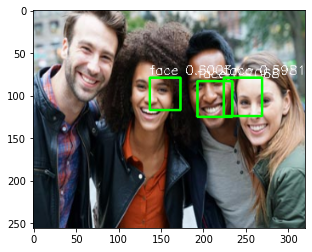

In [56]:
filepath = os.path.join(PROJECT_PATH, 'checkpoints', 'weights_epoch_008.h5')
model.load_weights(filepath)

TEST_IMAGE_PATH = os.path.join(PROJECT_PATH, 'image_people.png')

img_raw = cv2.imread(TEST_IMAGE_PATH)
img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
img = np.float32(img_raw.copy())

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
img = img / 255.0

boxes = default_box()
boxes = tf.cast(boxes, tf.float32)

predictions = model.predict(img[np.newaxis, ...])

pred_boxes, labels, scores = parse_predict(predictions, boxes)
pred_boxes = recover_pad(pred_boxes, pad_params)

for box_index in range(len(pred_boxes)):
    draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)

plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
plt.show()

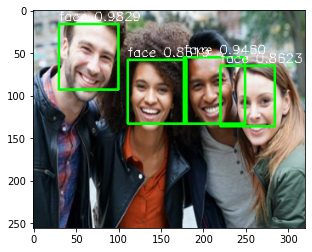

In [57]:
filepath = os.path.join(PROJECT_PATH, 'training_checkpoints', 'weights_epoch_085.h5')
model.load_weights(filepath)

TEST_IMAGE_PATH = os.path.join(PROJECT_PATH, 'image_people.png')

img_raw = cv2.imread(TEST_IMAGE_PATH)
img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
img = np.float32(img_raw.copy())

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
img = img / 255.0

boxes = default_box()
boxes = tf.cast(boxes, tf.float32)

predictions = model.predict(img[np.newaxis, ...])

pred_boxes, labels, scores = parse_predict(predictions, boxes)
pred_boxes = recover_pad(pred_boxes, pad_params)

for box_index in range(len(pred_boxes)):
    draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)

plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
plt.show()

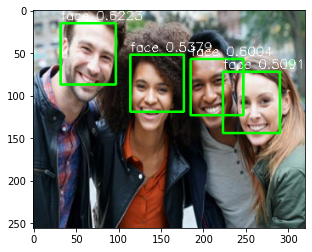

In [59]:
filepath = os.path.join(PROJECT_PATH, 'lr_checkpoints', 'weights_epoch_060.h5')
model.load_weights(filepath)

TEST_IMAGE_PATH = os.path.join(PROJECT_PATH, 'image_people.png')

img_raw = cv2.imread(TEST_IMAGE_PATH)
img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
img = np.float32(img_raw.copy())

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
img = img / 255.0

boxes = default_box()
boxes = tf.cast(boxes, tf.float32)

predictions = model.predict(img[np.newaxis, ...])

pred_boxes, labels, scores = parse_predict(predictions, boxes)
pred_boxes = recover_pad(pred_boxes, pad_params)

for box_index in range(len(pred_boxes)):
    draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)

plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
plt.show()

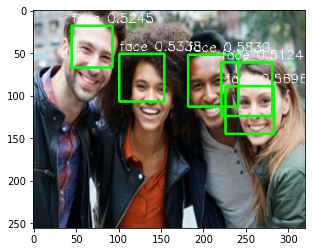

In [63]:
filepath = os.path.join(PROJECT_PATH, 'lr_checkpoints', 'weights_epoch_030.h5')
model.load_weights(filepath)

TEST_IMAGE_PATH = os.path.join(PROJECT_PATH, 'image_people.png')

img_raw = cv2.imread(TEST_IMAGE_PATH)
img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
img = np.float32(img_raw.copy())

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
img = img / 255.0

boxes = default_box()
boxes = tf.cast(boxes, tf.float32)

predictions = model.predict(img[np.newaxis, ...])

pred_boxes, labels, scores = parse_predict(predictions, boxes)
pred_boxes = recover_pad(pred_boxes, pad_params)

for box_index in range(len(pred_boxes)):
    draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)

plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
plt.show()

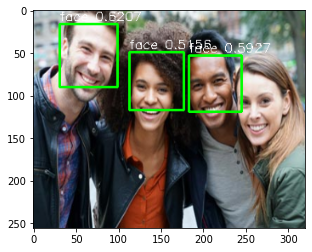

In [60]:
filepath = os.path.join(PROJECT_PATH, 'lr_checkpoints', 'weights_epoch_065.h5')
model.load_weights(filepath)

TEST_IMAGE_PATH = os.path.join(PROJECT_PATH, 'image_people.png')

img_raw = cv2.imread(TEST_IMAGE_PATH)
img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
img = np.float32(img_raw.copy())

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
img = img / 255.0

boxes = default_box()
boxes = tf.cast(boxes, tf.float32)

predictions = model.predict(img[np.newaxis, ...])

pred_boxes, labels, scores = parse_predict(predictions, boxes)
pred_boxes = recover_pad(pred_boxes, pad_params)

for box_index in range(len(pred_boxes)):
    draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)

plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
plt.show()

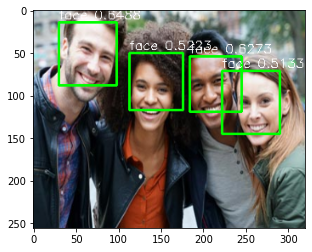

In [61]:
filepath = os.path.join(PROJECT_PATH, 'lr_checkpoints', 'weights_epoch_095.h5')
model.load_weights(filepath)

TEST_IMAGE_PATH = os.path.join(PROJECT_PATH, 'image_people.png')

img_raw = cv2.imread(TEST_IMAGE_PATH)
img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
img = np.float32(img_raw.copy())

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
img = img / 255.0

boxes = default_box()
boxes = tf.cast(boxes, tf.float32)

predictions = model.predict(img[np.newaxis, ...])

pred_boxes, labels, scores = parse_predict(predictions, boxes)
pred_boxes = recover_pad(pred_boxes, pad_params)

for box_index in range(len(pred_boxes)):
    draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)

plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
plt.show()

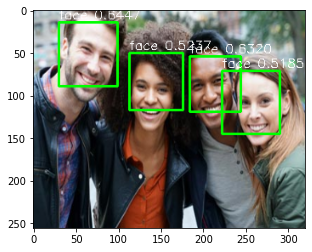

In [62]:
filepath = os.path.join(PROJECT_PATH, 'lr_checkpoints', 'weights_epoch_100.h5')
model.load_weights(filepath)

TEST_IMAGE_PATH = os.path.join(PROJECT_PATH, 'image_people.png')

img_raw = cv2.imread(TEST_IMAGE_PATH)
img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
img = np.float32(img_raw.copy())

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
img = img / 255.0

boxes = default_box()
boxes = tf.cast(boxes, tf.float32)

predictions = model.predict(img[np.newaxis, ...])

pred_boxes, labels, scores = parse_predict(predictions, boxes)
pred_boxes = recover_pad(pred_boxes, pad_params)

for box_index in range(len(pred_boxes)):
    draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)

plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
plt.show()

# 프로젝트 : 스티커를 붙여주자

- Step 1. 스티커 구하기 혹은 만들기
- Step 2. SSD 모델을 통해 얼굴 bounding box 찾기
  - 잘 훈련된 해당 모델을 통해 적절한 얼굴 bounding box를 검출
  - inference.py 코드를 적극적으로 참고
- Step 3. dlib 을 이용한 landmark 찾기 (선택사항)
  - 검출된 bounding box에 dlib을 적용해 face landmark를 찾을 수 있음
  - dlib를 이용하려는 경우, inference.py 에서 show_image 메소드를 사용한 부분을 적절히 수정
- Step 4. 스티커 합성 사진 생성하기

[sticker code](./0311_face_detection-sticker.ipynb)